# Bias correcting daily WRF precipitation using a probabilistic neural network  

### Import required packages 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import os, shutil, time, pdb, random
import scipy.stats as stats 
import scipy

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader 

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from seasonal_analysis import * 

# from shapely.geometry import box, mapping
import descartes

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc_file_defaults()
%matplotlib inline

import rasterio
from rasterio.plot import show

import seaborn as sns
from tabulate import tabulate
# sns.set_theme()

pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

### Import data

In [3]:
# Parameters
start="1998-01-01"
end="2007-12-31"

TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"
TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"

In [4]:
st = (import_dataframe(TRAIN_PATH)
    .pipe(drop_df_NaNs, series='Prec')
    .pipe(clip_time_period, start, end)
    .pipe(add_year_month_season)
    )  

st = filter_complete_station_years(st)

# st['set'] = "train" 

# st_val = (import_dataframe(TEST_PATH) # Import dataframe
#     .pipe(drop_df_NaNs, series='Prec') # Drop NaNs
#     .pipe(clip_time_period, start, end) # Clip data temporally 
# )

# st_val['set'] = "test"

In [5]:
# List bias-corrected and non-bias-corrected stations
bc_stations = list_bc_stations(st)
non_bc_stations = disjunctive_union_lists(st['Station'].unique(), bc_stations)

In [6]:
# Append validation stations to training 
# st = st.append(st_val)

In [7]:
# Filter by basin
filter_by_basin_flag = False
if filter_by_basin_flag:
    st = st[st['Basin']=='Sutlej']

In [15]:
st = add_yesterday_observation(st)

### Split data into held out sets for single model run

We will start by defining the set of stations to be split into training, validation and test held out sets.

In [16]:
# If True, validation and test sets will only include bias corrected stations.
split_bias_corrected_only = True

# Set of stations to be split into training, validation and test held out sets.
if split_bias_corrected_only:
    st_names = list(set(bc_stations) & set(st['Station'].unique()))
else:
    st_names = st['Station'][st['set']=='train'].unique()

# st_names_test = st['Station'][st['set']=='test'].unique()
st_names = np.array(st_names)

In [17]:
# Random selection of locations for train and test
np.random.shuffle(st_names)

split = round(len(st_names) * 0.2)

st_names_dict = {}

non_bc_st_names = non_bc_stations # list(set(list(st['Station'].unique())) - set(list(st_names)))

# st_names_dict['train'] = list(st_names)#[:split*4])
# st_names_dict['val'] = list(st_names_test)#[split*4:])
# st_names_dict['test'] = list(st_names_test)

st_names_dict['train'] = list(st_names[:split*3])    
st_names_dict['val'] = list(st_names[split*3:split*4])
st_names_dict['test'] = list(st_names[split*4:split*5]) 

include_non_bc_stations = True

if include_non_bc_stations:
    st_names_dict['train'] += non_bc_st_names

print("%s stations used for training, %s used for validation, and %s used testing" % (len(st_names_dict['train']), len(st_names_dict['val']), len(st_names_dict['test'])))

44 stations used for training, 6 used for validation, and 6 used testing


### Split data into held out sets for K-fold cross validation

In [20]:
split_by = 'station'
include_non_bc_stations = True

if split_by == 'station':
    
    split_dict = {}
    kf = KFold(n_splits=10,shuffle=True)
    #kf.get_n_splits(st_names)

    for i, (train_index, test_index) in enumerate(kf.split(st_names)):
        k = round(len(train_index)*0.8)
        split_dict[f'k{i}'] = {f'train': list(st_names[train_index[:k]]) + non_bc_st_names if include_non_bc_stations else list(st_names[train_index[:k]]),
                               f'val' : st_names[train_index[k:]],
                               f'test' : st_names[test_index[:]]
                              }
        
elif split_by == 'year':
    
    split_dict = {}
    kf = KFold(n_splits=5, shuffle=True)
    years=np.array(range(1998,2008))

    for i, (train_index, test_index) in enumerate(kf.split(years)):
        k = round(len(train_index)*0.75)
        split_dict[f'k{i}'] = {f'train': list(years[train_index[:k]]),
                               f'val' : years[train_index[k:]],
                               f'test' : years[test_index[:]]
                              }

In [21]:
# loaded_dictionary = pickle.load(open("split_dict.pickle", "rb"))
# loaded_dictionary

In [22]:
# split_dict = loaded_dictionary.copy()

In [23]:
# print("# Split dict:")
# for k,v in split_dict.items():
#     print(" " + k)
#     for kk,vv in v.items():
#         print(f"  {kk} = {len(vv)}")
#         print(vv)

### Prepare data

In [108]:
data = {}

predictors = [
                'wrf_prcp',
                'wrf_prcp_-2','wrf_prcp_-1','wrf_prcp_1','wrf_prcp_2',
                'Z',
                #'doy',
                'doy_sin',
                'doy_cos',
                'X',
                'Y',
                'aspect',
                'slope',
                'year',
                'obs_yesterday',
                'era5_u','era5_u_-1','era5_u_-2','era5_u_1','era5_u_2',
                'era5_v','era5_v_-1','era5_v_-2','era5_v_1','era5_v_2',
             ]

predictant = ['Prec']

In [109]:
# with open('split_dict.pickle', 'wb') as handle:
#     pickle.dump(split_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [110]:
sort_by_quantile_flag = True
if sort_by_quantile_flag:
    st = sort_by_quantile(st)

In [118]:
X = st[predictors].to_numpy()

x_mean = X.mean(axis=0)
x_std = X.std(axis=0)

for i in range(len(split_dict)):

    if split_by=='station':
        
        data[f'set_train_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['train'])]
        data[f'set_val_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['val'])]
        data[f'set_test_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['test'])]
                                
        if sort_by_quantile_flag:
            data[f'set_train_{i}'] = sort_by_quantile(data[f'set_train_{i}'])
            data[f'set_val_{i}'] = sort_by_quantile(data[f'set_val_{i}'])
                                
        data[f'X_train_{i}'] = (data[f'set_train_{i}'][predictors].to_numpy() - x_mean) / x_std
        data[f'X_val_{i}'] = (data[f'set_val_{i}'][predictors].to_numpy() - x_mean) / x_std
        data[f'X_test_{i}'] = (data[f'set_test_{i}'][predictors].to_numpy() - x_mean) / x_std

        data[f'Y_train_{i}'] = data[f'set_train_{i}'][predictant].to_numpy()
        data[f'Y_val_{i}'] = data[f'set_val_{i}'][predictant].to_numpy()
        data[f'Y_test_{i}'] = data[f'set_test_{i}'][predictant].to_numpy()

    
    elif split_by=='year':
    
        data[f'X_train_{i}'] = (st[st['year'].isin(split_dict[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_val_{i}'] = (st[st['year'].isin(split_dict[f'k{i}']['val'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_test_{i}'] = (st[st['year'].isin(split_dict[f'k{i}']['test'])][predictors].to_numpy() - x_mean) / x_std

        data[f'Y_train_{i}'] = st[st['year'].isin(split_dict[f'k{i}']['train'])][predictant].to_numpy()
        data[f'Y_val_{i}'] = st[st['year'].isin(split_dict[f'k{i}']['val'])][predictant].to_numpy()
        data[f'Y_test_{i}'] = st[st['year'].isin(split_dict[f'k{i}']['test'])][predictant].to_numpy()

# data['X_test'] = (st[st['Station'].isin(st_names_dict['test'])][predictors].to_numpy() - x_mean) / x_std
# data['Y_test'] = st[st['Station'].isin(st_names_dict['test'])][predictant].to_numpy()

# data['X_test2'] = (st_val[predictors].to_numpy() - x_mean) / x_std
# data['Y_test2'] = st_val[predictant].to_numpy()

### Train model with single run

In [119]:
def create_dataset(data, split, d):
    tensor_x = torch.Tensor(data[f'X_{split}'][:,:d])
    tensor_y = torch.Tensor(data[f'Y_{split}'][:,:d])
    return TensorDataset(tensor_x, tensor_y)

In [120]:
years_dict = {}
years_dict['train'] = list(range(1998,2008))

years_list = disjunctive_union_lists(list(st['year'].unique()),list(range(1998,2008)))
random.Random(5).shuffle(years_list)

years_dict['val'] = years_list[:10] #list(range(2004,2006))
years_dict['test'] = years_list[10:] #list(range(2006,2008))

In [121]:
d = len(predictors) # define number of input dimensions

splits = ['train', 'val', 'test']

# years = range(1998,2005)

for i in splits:
    
    if split_by=='station':
        data[f'X_{i}'] = (st[st['Station'].isin(st_names_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
        data[f'Y_{i}'] = st[st['Station'].isin(st_names_dict[f'{i}'])][predictant].to_numpy()

    elif split_by=='year':
        data[f'X_{i}'] = (st[st['year'].isin(years_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
        data[f'Y_{i}'] = st[st['year'].isin(years_dict[f'{i}'])][predictant].to_numpy()
        
train_dataset = create_dataset(data=data,split='train',d=d)
val_dataset = create_dataset(data=data,split='val',d=d)
test_dataset = create_dataset(data=data,split='test',d=d)
    
# train_tensor_x = torch.Tensor(data['X_train'][:,:d]) # transform to torch tensor
# train_tensor_y = torch.Tensor(data['Y_train'][:,:d])
# train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create your dataset

# val_tensor_x = torch.Tensor(data['X_val'][:,:d]) # transform to torch tensor
# val_tensor_y = torch.Tensor(data['Y_val'][:,:d])
# val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create your dataset

# test_tensor_x = torch.Tensor(data['X_test'][:,:d]) # transform to torch tensor
# test_tensor_y = torch.Tensor(data['Y_test'][:,:d])
# test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create your dataset

# test2_tensor_x = torch.Tensor(data['X_test2'][:,:d]) # transform to torch tensor
# test2_tensor_y = torch.Tensor(data['Y_test2'][:,:d])
# test2_dataset = TensorDataset(test2_tensor_x,test2_tensor_y) # create your dataset

In [122]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

In [123]:
model = MLP(in_channels=d, 
            hidden_channels=[30], 
            likelihood_fn='b2gmm', # 'gaussian', gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
            linear_model=False
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 936


In [124]:
experiment_name = f'MLP_{model.likelihood}'
wd = WorkingDirectory(generate_root(experiment_name))

# Save model parameters
arg_list = ['in_channels','hidden_channels','likelihood','dropout_rate','linear_model']
model_args = {}

for k in arg_list:
    model_args[k] = getattr(model, k)

with open(os.path.join(wd.root,'model_args.pickle'), 'wb') as handle:
    pickle.dump(model_args, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_losses = []
val_losses = []
test_losses = []

epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):

    train_loss, val_loss, test_loss = train_epoch(model, optimizer, train_loader, valid_loader, test_loader=test_loader, print_progress=True, epoch=epoch)
    
    # wandb.log({"train_loss":train_loss, "val_loss":val_loss, "test_loss":test_loss})
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    save_as_best = True if val_loss == min(val_losses) else False
    save_checkpoint(wd,model.state_dict(),is_best=save_as_best)
    
    PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
    torch.save(model.state_dict(), PATH)

BEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
model.load_state_dict(torch.load(BEST_PATH))

Root: _experiments/2021-11-03_12-38-03_mlp-b2gmm
epoch : 1, train loss : 1.1476, valid loss : 0.8738
epoch : 2, train loss : 0.8324, valid loss : 0.7014
epoch : 3, train loss : 0.7321, valid loss : 0.6416
epoch : 4, train loss : 0.6785, valid loss : 0.6169
epoch : 5, train loss : 0.6389, valid loss : 0.6327
epoch : 6, train loss : 0.6072, valid loss : 0.6224
epoch : 7, train loss : 0.5798, valid loss : 0.6705
epoch : 8, train loss : 0.5589, valid loss : 0.7274
epoch : 9, train loss : 0.5397, valid loss : 0.7436
epoch : 10, train loss : 0.5262, valid loss : 0.8251
epoch : 11, train loss : 0.5121, valid loss : 0.7783
epoch : 12, train loss : 0.5002, valid loss : 0.8598
epoch : 13, train loss : 0.4911, valid loss : 0.9499
epoch : 14, train loss : 0.4849, valid loss : 0.9467
epoch : 15, train loss : 0.4781, valid loss : 1.0504
epoch : 16, train loss : 0.4713, valid loss : 1.0197
epoch : 17, train loss : 0.4654, valid loss : 1.0517
epoch : 18, train loss : 0.4598, valid loss : 1.1075
epoch 

<All keys matched successfully>

In [125]:
LOAD_CHECKPOINT = False
LOAD_MODELBEST = True

if LOAD_CHECKPOINT and LOAD_MODELBEST:
    print("\n Both LOAD_CHECKPOINT and LOAD_MODELBEST flags are set to True. \n PLEASE SET ONLY ONE TO TRUE")

elif LOAD_CHECKPOINT:
    CHECKPOINT_PATH = os.path.join(wd.root,'checkpoint.pth.tar')
    model.load_state_dict(torch.load(CHECKPOINT_PATH))

elif LOAD_MODELBEST:
    MODELBEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
    model.load_state_dict(torch.load(MODELBEST_PATH))

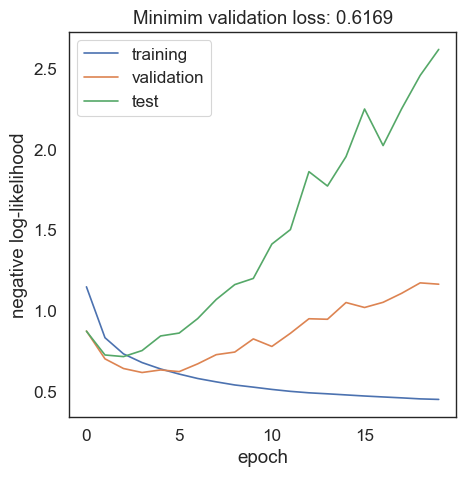

In [126]:
sns.set_theme(context='paper',style='white',font_scale=1.4)
# with sns.plotting_context("talk", rc={"lines.linewidth": 2}):
plt.figure(figsize=(5,5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(test_losses)
plt.legend(["training","validation","test"])
plt.xlabel('epoch')
plt.ylabel('negative log-likelihood')
plt.title(f"Minimim validation loss: {min(val_losses):.4f}")
plt.show()

In [127]:
# PATH = '../../PhD/data/pickle/df_map1.pkl'
# test_map = pd.read_pickle(PATH)

# data['X_map'] = (test_map[predictors].to_numpy() - x_mean) / x_std

# model.eval()

# with torch.no_grad():
#     map_inputs = torch.Tensor(data['X_map'][:,:d])
#     map_outputs = model(map_inputs)

In [128]:
# %%time
# map_results = build_results_df(test_map,
#                        outputs=map_outputs,
#                        st_names_test=None,
#                        model=model,
#                        p=0.05,
#                        confidence_intervals=True)

In [129]:
# from scipy.interpolate import griddata

# xRange = np.sort(map_results['X'].unique())
# yRange = np.sort(map_results['Y'].unique())
# points = list(zip(map_results.X,map_results.Y))
# values = map_results['wrf_prcp'].values

# #create arrays of x,y over the raster extension
# gridX,gridY = np.meshgrid(xRange,yRange)

# #interpolate over the grid
# gridValues = griddata(points, values, (gridX,gridY), method='linear')

# #show interpolated values
# plt.imshow(gridValues)
# plt.gca().invert_yaxis()
# plt.xticks([]), plt.yticks([])
# plt.show()

In [130]:
# n = 2
# fig, axes = plt.subplots(1,n,figsize=(n*5 + 5, 5))
# cols = ['wrf_prcp','sample_0','high_ci','low_ci','Z']
# labels = ['WRF', 'Samples']
# a = ['a','b']

# map_results = build_results_df(test_map,
#                            outputs=map_outputs,
#                            st_names_test=None,
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True,
#                            )

# for index, ax in enumerate(axes.flatten()):
    
#     if index < len(cols):
#         col = cols[index]
#     else:
#         col = cols[-1]
    
#     ax.scatter(x=map_results['X'], y=map_results['Y'], c=map_results[col], cmap="viridis")
#     #ax.set_title(labels[index], fontsize=16)
#     ax.set_xticklabels([]), ax.set_yticklabels([])
#     ax.set_frame_on(False)
#     ax.set_xticks([]), ax.set_yticks([])
#     #ax.set_frame_on(True)
    
#     ax.text(0.06, 0.90, f'{a[index]}', fontweight="bold", transform=ax.transAxes, size='large', color='white')#bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
# plt.tight_layout(w_pad=-1.5)
# plt.savefig('figures/sampled_map', dpi=300)
# plt.show()

In [131]:
model.eval()

with torch.no_grad():
    
    test_inputs = test_dataset.tensors[0]
    test_outputs = model(test_inputs)

#     test2_inputs = test2_dataset.tensors[0]
#     test2_outputs = model(test2_inputs)

In [134]:
# model.eval()

# with torch.no_grad():
#     for index in range(len(test_dataset.tensors[0])):
#         if index==0:
#             a = torch.tensor(0)
#         else:
#             a = torch.tensor(norm_sample)
            
#         test_inputs = torch.cat([test_dataset.tensors[0][index,:-1],a.unsqueeze(0)])
        
#         test_outputs = model(test_inputs.unsqueeze(0).float())
        
#         theta_params = ['pi','alpha','beta']
        
#         theta_dict = {key:test_outputs[0,i] for i, key in enumerate(theta_params)}
        
#         sample = sample_mc(model, theta_dict)
        
# #         sample = truncate_sample(sample, threshold=350)
        
#         norm_sample = (sample - x_mean[-1])/x_std[-1]
        
#         if index==0:
#             bs = torch.cat([test_outputs.squeeze(),torch.tensor(sample).unsqueeze(0)]).unsqueeze(0)
#         else:
#             b = torch.cat([test_outputs.squeeze(),torch.tensor(sample).unsqueeze(0)]).unsqueeze(0)
#             bs = torch.cat([bs,b],dim=0)
        
#         print(index) if index%10000==0 else None

### Histograms of predicted parameter values 

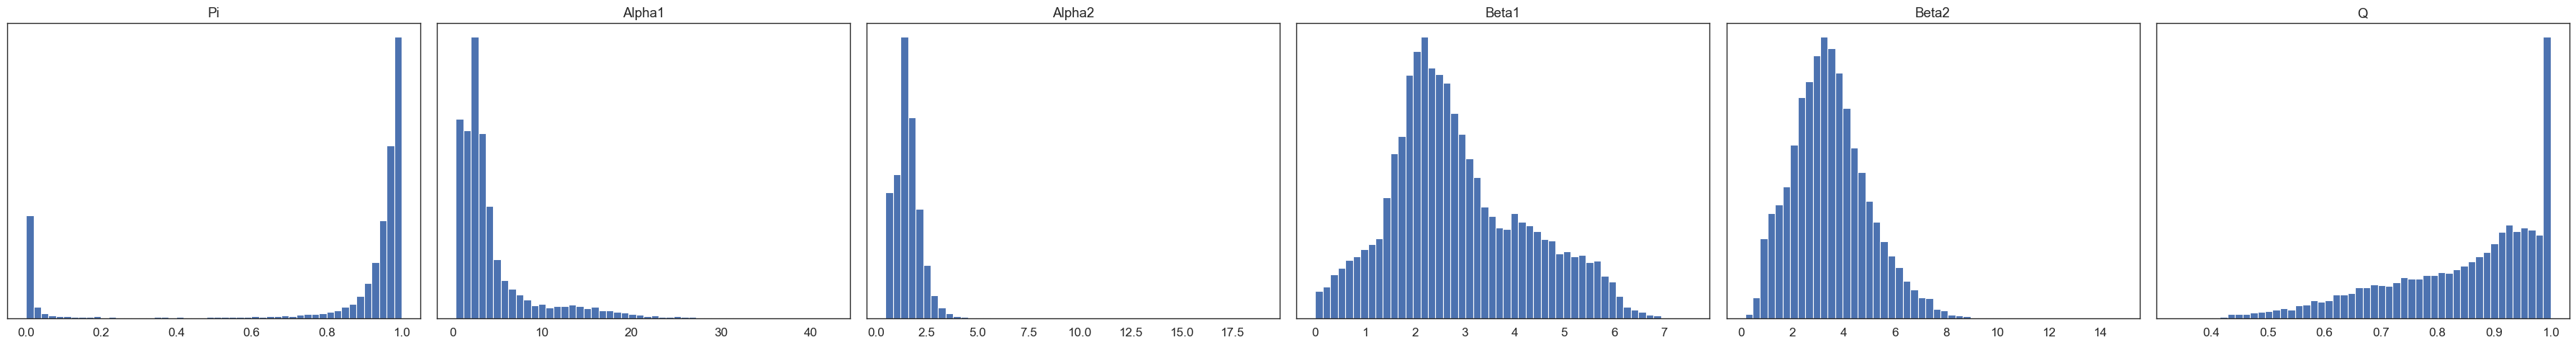

In [135]:
sns.set_theme(context='paper',style='white',font_scale=1.4)
plot_parameter_histograms(model, test_outputs)
plt.tight_layout()
plt.savefig('figures/parameter_histograms.png',dpi=300)
plt.show()

In [136]:
# # %%capture

# sns.set_theme(context='paper',style='white',font_scale=1.4)

# title_labels = ['pi', 'alpha', 'beta'] 

# fig, axes = plt.subplots(1,3, figsize=(15,5))

# for idx, ax in enumerate(axes.flatten()):
#     for i in [0,1,5,10,50,100]:
#         zero_wrf = test_dataset.tensors[0][:,0].mode()[0] 
#         test_inputs = test_dataset.tensors[0].clone()
#         test_inputs[:,0:1] = zero_wrf + (i-x_mean[0])/x_std[0]
#         model.eval()
#         with torch.no_grad():
#             test_outputs = model(test_inputs)
#         if idx==0:
#             ax.plot(1-test_outputs[:,idx], label=i, linewidth=1.5)
#         else:
#             ax.plot(test_outputs[:,idx], label=i, linewidth=1.5)
#     if idx==1:
#         ax.legend(title="P$_{SIM}$ (mm/day)", loc="lower left")
#     ax.set_xlim(0,365)
#     ax.set_xticks([0,365])
#     #ax.set_title(title_labels[idx])
#     ax.set_xlabel("Day of year")
#     ax.set_ylabel(title_labels[idx].capitalize())
        
# plt.tight_layout()
# plt.savefig('figures/parameter_timeseries.png',dpi=300)
# plt.show()

In [138]:
%%capture

# sns.set_theme()
# list_of_stations = ['Berthin','Daslehra']
# # fig, axes = plt.subplots(1,2,figsize=(10,5))
# # for idx, ax in enumerate(axes.flatten()):
# #     s = list_of_stations[idx]
# #     df = st_test[st_test['Station']==s]
# #     y = df['sample']-df['Prec']
# #     ax.scatter(x=df['Prec'],y=y,label=s)
# #     ax.legend()

# df = clip_time_period(st_test,'2000-01-01','2005-01-31')
# df = df[df['Station'].isin(list_of_stations)]
# df['residuals'] = df['sample'] - df['Prec']
# #df.groupby(['Station'])['wrf_prcp'].first().unstack()#.unstack()
# df = df.pivot(index='Date',
#         columns='Station',
#         values='residuals')

# df.dropna(inplace=True)
# # df1 = df[df['Station']=='Sainj']
# # y1 = df1['wrf_prcp']-df1['Prec']
# # df2 = df[df['Station']=='Larji']
# # y2 = df2['wrf_prcp']-df2['Prec']
# plt.scatter(df[list_of_stations[0]],df[list_of_stations[1]])
# plt.show()

# np.corrcoef(df[list_of_stations[0]],df[list_of_stations[1]])

### Plot sample distribution

In [139]:
# plot_sample_distribution(model, outputs, test_dataset, force_non_zero=True)

### Summary of results

In [140]:
n_samples = 1

In [141]:
# st_test = st[(st['year'].isin(years_dict['test']))]
# st_test[['pi','alpha','beta','sample_0']] = bs.numpy()

In [142]:
st_names_dict['test']

['Pandoh', 'Swaghat', 'SuniIMD', 'Rampur', 'Jogindernagar', 'Kaza']

In [143]:
%%time

if split_by == 'year':
    input_df = st[(st['year'].isin(years_dict['test']))].copy()
    input_st_names = None 
elif split_by == 'station':
    input_df = st.copy()
    input_st_names = st_names_dict['test']
    

st_test = build_results_df(df=input_df,
                           outputs= test_outputs, #bs[:,:3],#test_outputs,
                           st_names_test=input_st_names, #st_names_dict['test'],
                           model=model,
                           p=0.05,
                           confidence_intervals=True,
                           draw_samples=True,
                           n_samples=n_samples)

CPU times: user 48.1 s, sys: 109 ms, total: 48.2 s
Wall time: 48.3 s


In [144]:
# st_test['sample_0'] = bs[:,-1]

In [145]:
st_test = st_test[st_test['Station'].isin(st_names)].copy() if split_by == 'year' else st_test

In [146]:
# %%time
# st_test = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True,
#                            calculate_errors=True,
#                            n_samples=3)

In [147]:
# list_wet_days_mlp = []

# for i in range(10):
    
#     df = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

#     wet_days_mlp = (df['sample']!=0).sum()
#     # print(i, wet_days_mlp)

#     list_wet_days_mlp.append(wet_days_mlp)
    
# wet_days_reg = (df['wrf_bc_prcp']!=0).sum()
# wet_days_obs = (df['Prec']!=0).sum()

In [148]:
# plt.plot(list_wet_days_mlp,'o')
# plt.plot([0,9],[np.mean(list_wet_days_mlp),np.mean(list_wet_days_mlp)])
# plt.plot([wet_days_obs]*10)
# plt.plot([wet_days_reg]*10)
# plt.show()

In [149]:
# np.mean(list_wet_days_mlp/wet_days_obs) , np.std(list_wet_days_mlp/wet_days_obs)

# print(f"Ratio of predicted vs actual wet days (BC): {wet_days_reg / wet_days_obs:.4f}")
# print(f"Ratio of predicted vs actual wet days (MLP): {np.mean(list_wet_days_mlp/wet_days_obs):.4f}")

In [150]:
# st_test = build_results_df(st_val,
#                            outputs=test2_outputs,
#                            st_names_test=st_val['Station'].unique(),
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

In [151]:
# predictions.keys()

In [199]:
st_test = predictions['bgmm_[30]_False']['k_all'].copy()

In [200]:
# st_test = st_test[st_test['Station'].isin(st_names)].copy()
st_test['sample_0'].sort_values(ascending=False).head(5)

95211     5.652741e+07
201956    3.071822e+06
87942     2.333195e+06
221423    2.304355e+06
344610    1.555976e+06
Name: sample_0, dtype: float64

In [201]:
almost_dry = 0
n_samples= 1

print(f"Ratio of predicted vs actual wet days (BC): {(st_test['wrf_bc_prcp']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

for i in range(n_samples):
    print(f"Ratio of predicted vs actual wet days (MLP) {i}: {(st_test[f'sample_{i}']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

for i in range(n_samples):
    tail_high = (st_test[f'sample_{i}']>st_test['high_ci']).sum()
    tail_low = (st_test[f'sample_{i}']<st_test['low_ci']).sum()

    print(f"Percentage of high outliers at 95% confidence: {(tail_high) / len(st_test):.4f}")
    print(f"Percentage of low outliers at 95% confidence: {(tail_low) / len(st_test):.4f}")

Ratio of predicted vs actual wet days (BC): 1.1797
Ratio of predicted vs actual wet days (MLP) 0: 1.0061
Percentage of high outliers at 95% confidence: 0.0434
Percentage of low outliers at 95% confidence: 0.0044


In [202]:
ci_dict = {}
dd_dict = {}
for s in st_test['Station'].unique():
    ci_dict[s] = []
    dd_dict[s] = []
    st_test_s = st_test[st_test["Station"]==s]
    for i in range(n_samples):
        tail_high = (st_test_s[f'sample_{i}']>st_test_s['high_ci']).sum()
        tail_low = (st_test_s[f'sample_{i}']<st_test_s['low_ci']).sum()
        ci_dict[s].append((tail_high + tail_low) / len(st_test_s))
        dd_dict[s].append((st_test_s[f'sample_{i}']>almost_dry).sum() / (st_test_s['Prec']>almost_dry).sum())

ci_means = []
dd_means = []
for k,v in ci_dict.items():
    ci_means.append(np.mean(v))
    #print(f'{k}: {np.mean(v):.4f}')
print(f'CI: {np.mean(ci_means)}')

for k,v in dd_dict.items():
    dd_means.append(np.mean(v))
    #print(f'{k}: {np.mean(v):.4f}')
print(f'DD: {np.mean(dd_means)}') 

CI: 0.04804017209097617
DD: 1.315185219680238


In [203]:
def truncate_sample(x, threshold=300):
    if x>threshold:
        return threshold
    else:
        return x

In [204]:
# st_test_nontruncated = st_test.copy()
    
# for i in range(n_samples):
#     st_test[f'sample_{i}'] = st_test[f'sample_{i}'].apply(lambda x: truncate_sample(x))

In [205]:
st_test = pairwise_errors(st_test)
pairwise_mse = st_test.groupby(['Station']).mean()[['se_wrf','se_bcp']+[f'se_mlp_sample_{i}' for i in range(n_samples)]].reset_index()
pairwise_mse.mean()

se_wrf             1.433693e+01
se_bcp             1.160832e+01
se_mlp_sample_0    3.068431e+10
dtype: float64

In [206]:
n_samples = 10

### Plot squared errors

In [207]:
sample_cols = [f'sample_{i}' for i in range(n_samples)]
add_cols = []

columns = ['Prec','wrf_prcp','wrf_bc_prcp'] + sample_cols + add_cols
labels = ['Obs', 'WRF', 'Bias corrected WRF','Sample (MLP)']
seasons = st_test['season'].unique()
basins = st_test['Basin'].unique()

In [208]:
#st_test['sample']=st_test['sample_1'].astype('float64').copy()

In [209]:
len(st_test['Station'].unique())

32

## Seasonal predictions

In [210]:
# st_test = st_test[st_test['median']>200]

### Analsys of results (per season per year)

In [213]:
df_annual = st_test.groupby(['Station','year','Basin']).sum()[columns].copy()
df_annual['sample'] = df_annual[sample_cols].mean(axis=1)

df_annual['se_wrf'] = (df_annual['wrf_prcp'] - df_annual['Prec'])**2
df_annual['se_wrf_bc'] = (df_annual['wrf_bc_prcp'] - df_annual['Prec'])**2

for i in range(n_samples):
    df_annual[f'se_mlp_{i}'] = (df_annual[f'sample_{i}'] - df_annual['Prec'])**2
df_annual['se_mlp'] = df_annual[[f'se_mlp_{i}' for i in range(n_samples)]].mean(axis=1)

# Totals
annual_totals = df_annual.reset_index().melt(id_vars=['Station','year','Basin'],
                      value_vars=['Prec','wrf_prcp','wrf_bc_prcp','sample'] + add_cols
                     )   

annual_se = df_annual.reset_index().melt(id_vars=['Station','year','Basin'],
                      value_vars=['se_wrf','se_wrf_bc','se_mlp']
                     )  

rmse = np.sqrt(annual_se.groupby(['Basin','variable']).mean())

In [215]:
%%time 
df = seasonal_analysis(st_test)
seasonal_dict = seasonal_summaries(df)

CPU times: user 2.72 s, sys: 6.97 ms, total: 2.72 s
Wall time: 2.72 s


In [216]:
df_multiyear = df.groupby(['Station','season']).mean()[columns + ['sample']].reset_index()
df_annual_multiyear = df_annual.groupby(['Station']).mean()[columns + ['sample']].reset_index()

table = []
sample_flag = 0 # 'all' or 0, 1, 2,...
sample_name = 'sample' if sample_flag == 'all' else f'sample_{sample_flag}'

for season in seasons:
    
    dfp = df_multiyear[df_multiyear['season']==season]
    a = abs(dfp['wrf_prcp'] - dfp['Prec'])/(dfp['wrf_prcp'] + dfp['Prec'])
    b = abs(dfp['wrf_bc_prcp'] - dfp['Prec'])/(dfp['wrf_bc_prcp'] + dfp['Prec'])
    c = abs(dfp[sample_name] - dfp['Prec'])/(dfp[sample_name] + dfp['Prec'])
    d = abs(dfp['sample'] - dfp['Prec'])/(dfp['sample'] + dfp['Prec'])
    row = [f'{season}', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{d.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}', f'{d.median():.2f}']
    table.append(row)

dfp = df_annual_multiyear
a = abs(dfp['wrf_prcp'] - dfp['Prec'])/(dfp['wrf_prcp'] + dfp['Prec'])
b = abs(dfp['wrf_bc_prcp'] - dfp['Prec'])/(dfp['wrf_bc_prcp'] + dfp['Prec'])
c = abs(dfp[sample_name] - dfp['Prec'])/(dfp[sample_name] + dfp['Prec'])
d = abs(dfp['sample'] - dfp['Prec'])/(dfp['sample'] + dfp['Prec'])
row = ['All year', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{d.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}', f'{d.median():.2f}']
table.append(row)

headers = ['Season', 'Mean WRF', 'Mean CANLR', 'Mean MLP', 'Mean MLP (k=10)', 
                     'Median WRF', 'Median CANLR', 'Median MLP', 'Median MLP (k=10)']

print(tabulate(table, headers, tablefmt='simple'))

Season               Mean WRF    Mean CANLR    Mean MLP    Mean MLP (k=10)    Median WRF    Median CANLR    Median MLP    Median MLP (k=10)
-----------------  ----------  ------------  ----------  -----------------  ------------  --------------  ------------  -------------------
Winter (JFM)             0.21          0.15        0.31               0.3           0.2             0.1           0.23                 0.21
Premonsoon (AM)          0.24          0.28        0.23               0.23          0.22            0.29          0.18                 0.17
Postmonsoon (OND)        0.2           0.14        0.36               0.36          0.2             0.12          0.36                 0.34
Monsoon (JJAS)           0.16          0.1         0.77               0.83          0.11            0.06          0.84                 0.87
All year                 0.17          0.12        0.76               0.82          0.14            0.07          0.86                 0.89


In [5]:
# sns.histplot(data=e[e['variable']=='e_mlp'], x='value')
# plt.show()

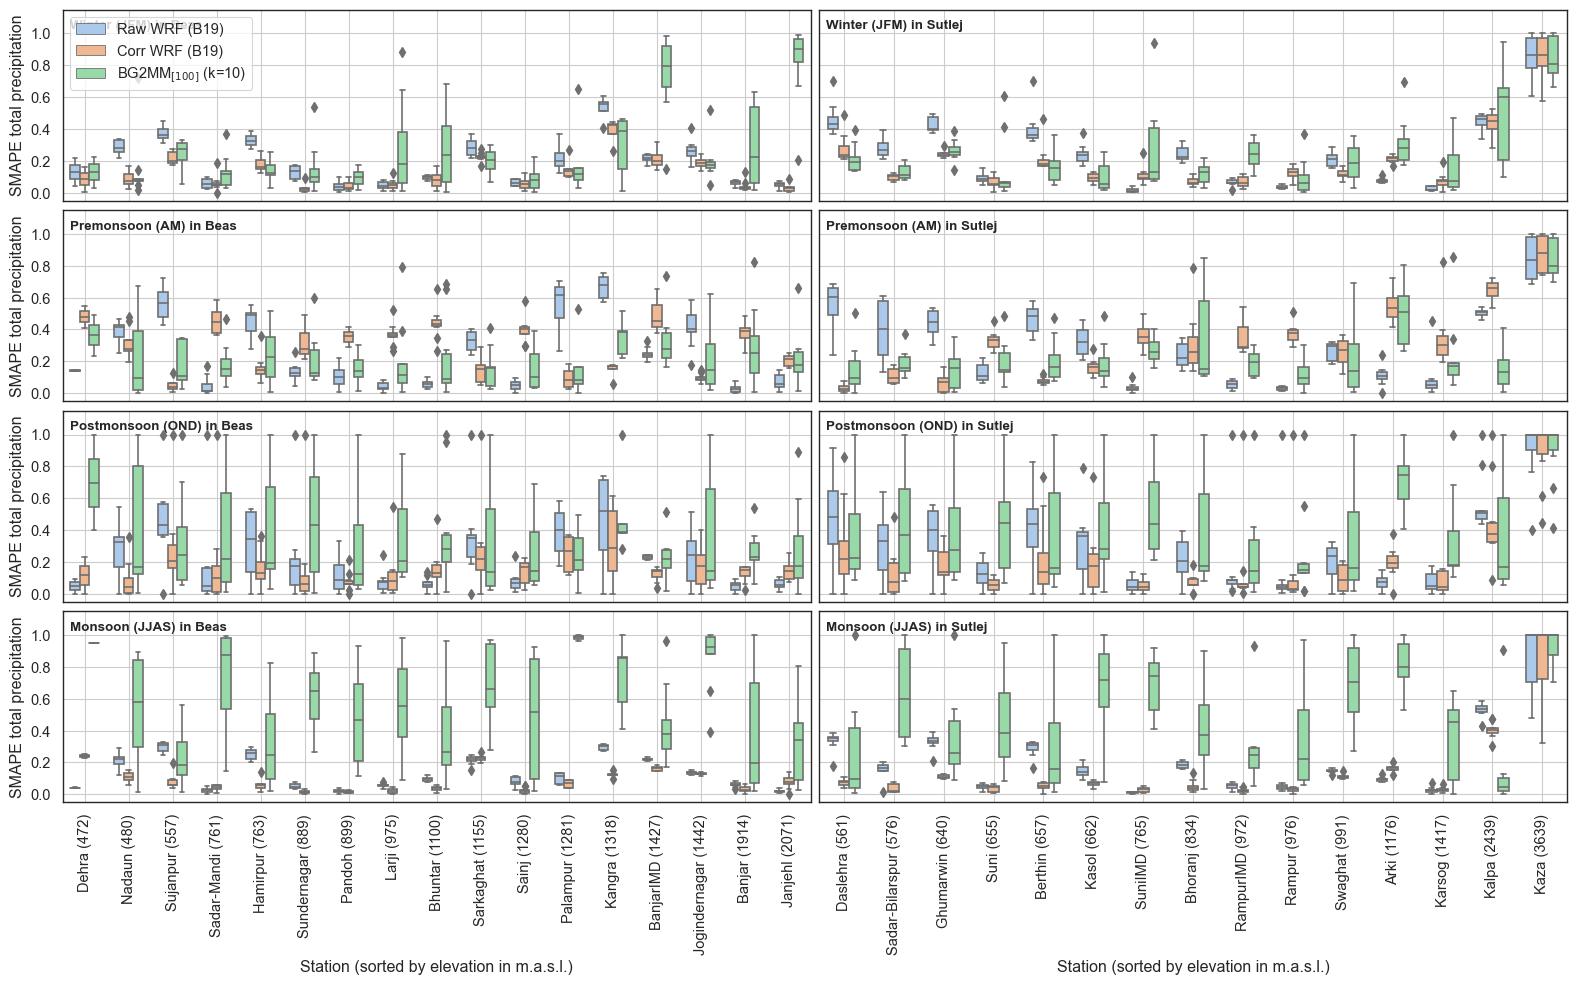

In [218]:
data1 = seasonal_dict['smape'].copy()
sns.set_theme(context='paper',style='white',font_scale=1.2)
new_labels = ['Raw WRF (B19)', 'Corr WRF (B19)','BG2MM$_{[100]}$ (k=10)']
# yaxislabel = 'Error reduction (mm)'

plot_seasonal_boxplot_per_station(data1, st_test, yaxislabel='SMAPE total precipitation', new_labels=new_labels, 
                                basins=basins, seasons=seasons, filter_by_basin_flag=filter_by_basin_flag, y_limits=[-0.05,1.15])

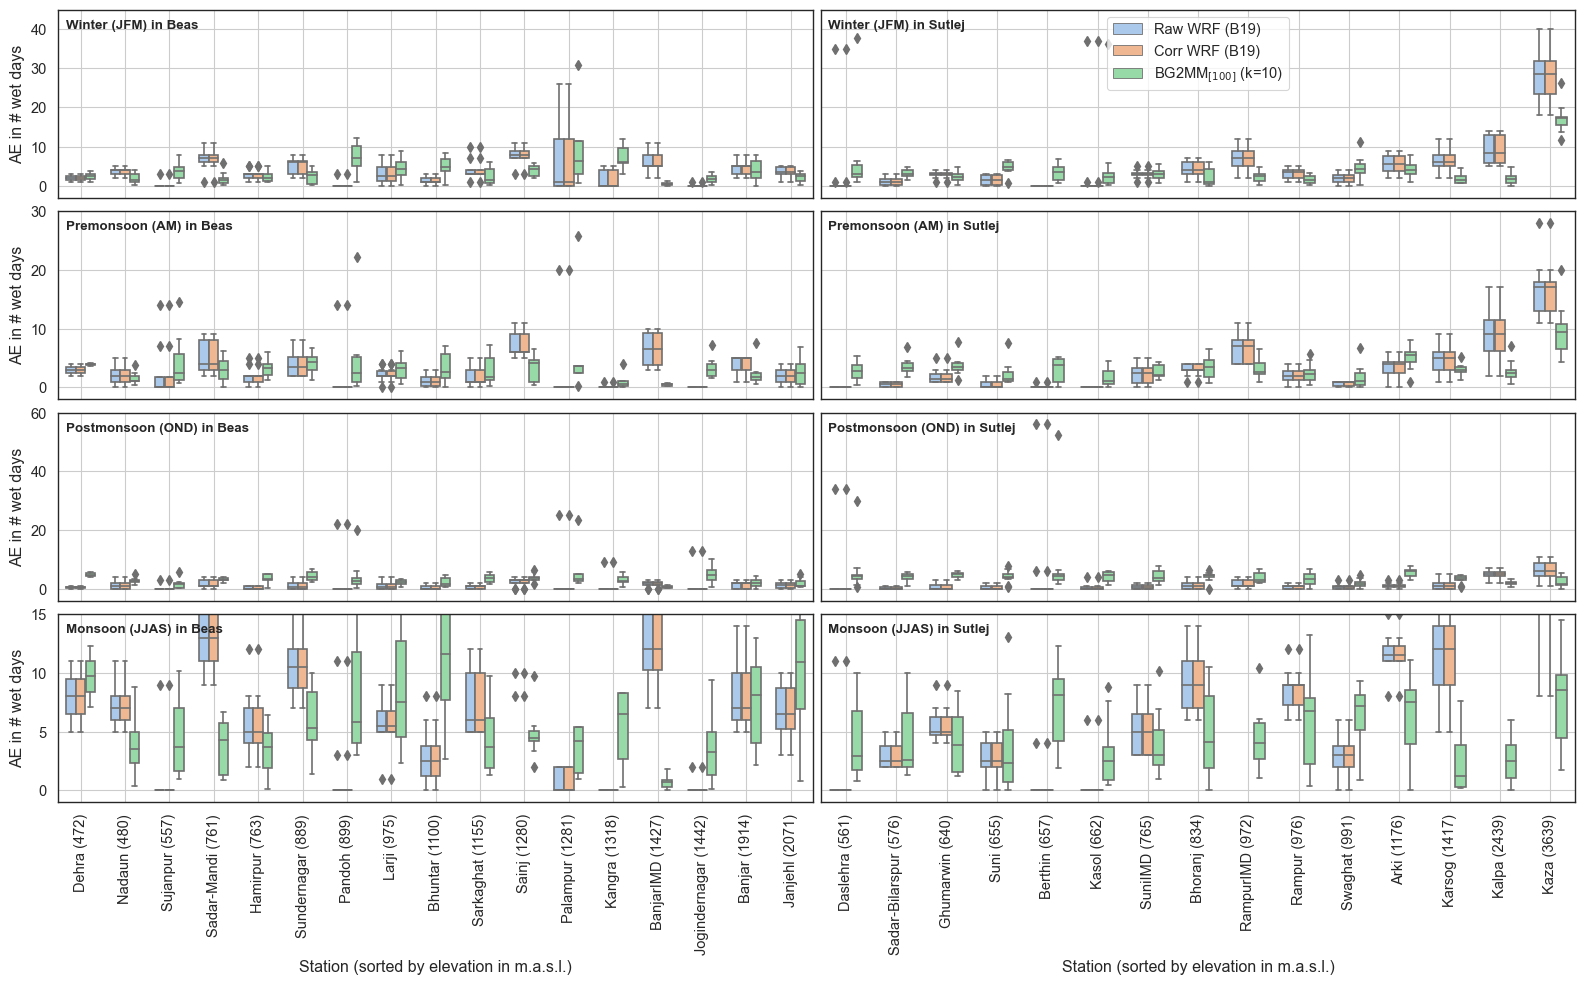

In [219]:
data1 = seasonal_dict['edd'].copy()
sns.set_theme(context='paper',style='white',font_scale=1.2)
new_labels = ['Raw WRF (B19)', 'Corr WRF (B19)','BG2MM$_{[100]}$ (k=10)']
plot_seasonal_boxplot_per_station(data1, st_test, yaxislabel='AE in # wet days', new_labels=new_labels, 
                                basins=basins, seasons=seasons, filter_by_basin_flag=filter_by_basin_flag, y_limits=[-0.05,1.15])

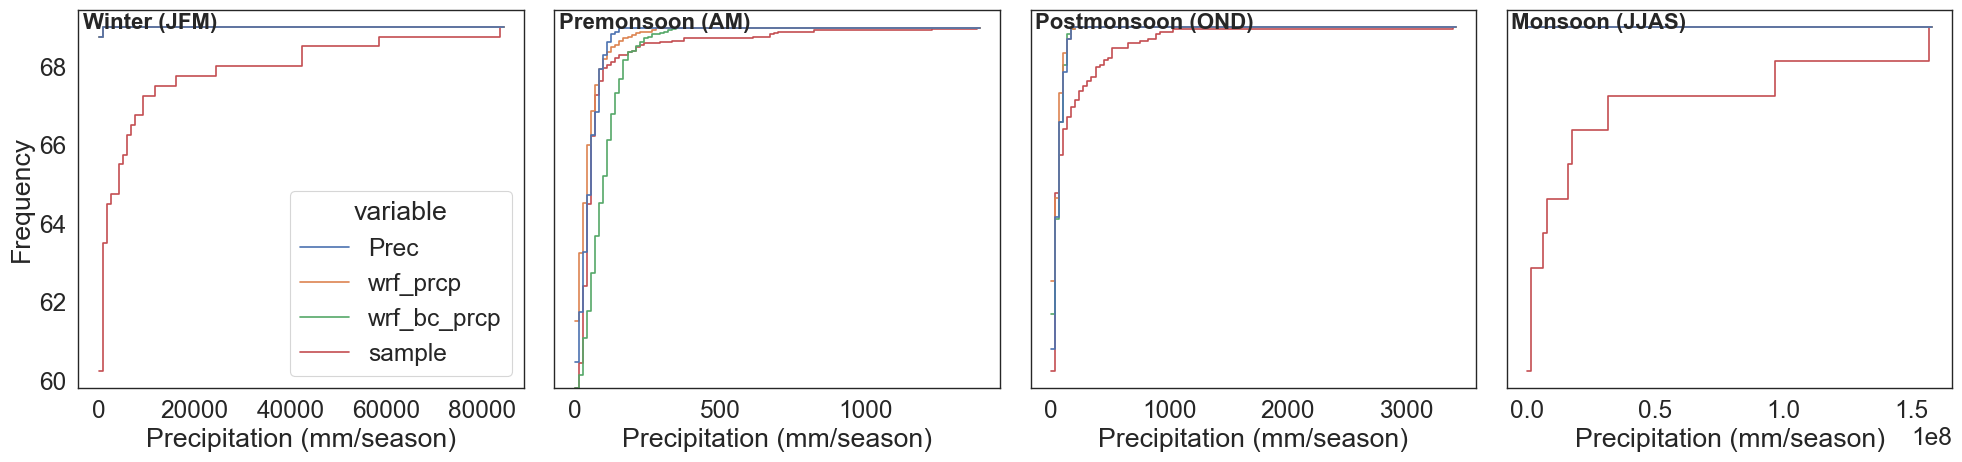

In [220]:
sns.set_theme(context='paper',style='white',font_scale=2)
plot_data = seasonal_dict['totals']
fig, axes = plt.subplots(1,4,figsize=(20,5))
for index, ax in enumerate(axes.flatten()):
    season = seasons[index]
    sns.histplot(data=plot_data[plot_data['season']==season],x='value',hue='variable', 
                 bins=100, multiple='layer', element='step', stat='frequency',
                 cumulative=True, fill=False, shrink=0.8, ax=ax)
    ax.text(0.01, 0.95, f'{season}', fontweight="demibold", transform=ax.transAxes, size='small')
    ax.get_legend().remove() if index>0 else None
    ax.set_yticklabels([]) if index>0 else None
    ax.set_ylabel('') if index>0 else None
    ax.set_xlabel('Precipitation (mm/season)')
    
plt.tight_layout()
plt.show()

### Seasonal over the entire period

In [174]:
# st_test_season_totals = st_test.groupby(['Station','season']).sum()
# st_test_annual_totals = st_test.groupby(['Station']).sum()

In [175]:
sns.set_theme(context='paper',style='white',font_scale=1.4)

fig, axes = plt.subplots(5,1, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):

    if i < 4: 

        season = seasons[i]
        df = st_test_season_totals[np.in1d(st_test_season_totals.index.get_level_values(1), [season])].copy()
        df = df.reset_index().set_index('Station')

    else: 
        df = st_test_annual_totals
        season = "Annual"

    legend = True if i==0 else None
    df[list(columns[l] for l in [0,1,2,3])].plot.bar(rot=45,ax=ax,legend=legend)

    df['se_wrf'] = (df['wrf_prcp'] - df['Prec'])**2
    df['se_bc_wrf'] = (df['wrf_bc_prcp'] - df['Prec'])**2
    df['se_mlp'] = (df['sample'] - df['Prec'])**2

    df['se_imp_bc_wrf'] = df['se_bc_wrf'] - df['se_wrf']
    df['se_imp_mlp'] = df['se_mlp'] - df['se_wrf']
    
    df['imp_bc_wrf'] = 1 - df['se_bc_wrf']/df['se_wrf']
    df['imp_mlp'] = 1 - df['se_mlp']/df['se_wrf']

#     ax.set_title("{0} \n\
#                 MSE improvement ratio | median baseline : {1:.2f} | median NN : {2:.2f} | mean baseline : {3:.2f} | mean NN : {4:.2f} \n \
#                 MSE improvement | median baseline : {5:.2f} | median NN : {6:.2f} | mean baseline : {7:.2f} | mean NN : {8:.2f} \n"
#         .format(season,
#                 df['imp_bc_wrf'].median(),
#                 df['imp_mlp'].median(),
#                 df['imp_bc_wrf'].mean(),
#                 df['imp_mlp'].mean(),
#                 df['se_imp_bc_wrf'].median(),
#                 df['se_imp_mlp'].median(),
#                 df['se_imp_bc_wrf'].mean(),
#                 df['se_imp_mlp'].mean()
#                )
#         )

    ax.set_title(f"{season}")

    ax.set_xlabel(None)
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xticklabels([]) if i < 4 else None

plt.tight_layout()

### Seasonal totals 

In [176]:
# predictions_0 = preditions_2.copy()
# print(predictions_0.keys())
# predictions_0.update(preditions_4)
# print(predictions_0.keys())
# predictions_0.update(preditions_3)
# print(predictions_0.keys())
# predictions_0.update(preditions_1)
# print(predictions_0.keys())
# predictions_0.update(preditions_5)
# print(predictions_0.keys())

In [177]:
# for k in predictions.keys():
#     k.replace('_'," ")
#     print(k.replace('_'," ").replace('True','L').replace('False','NL').replace('gamma','$\Gamma$'))

In [221]:
metric = 'smape'
prefix = 'smape'

table = []

headers = ['Model']
row_a = ['Raw WRF']
row_b = ['WRF BC']

for index, (k,v) in enumerate(predictions.items()):
    
    df = seasonal_analysis(v['k_all'])
    d = seasonal_summaries(df)

    r = d[metric].copy()
    
    row = [f'{k}']
    
    for season in seasons:
        
        if index == 0: 
            headers.append(f'{season} mean')
            headers.append(f'{season} median')
        
        rs = r[r['season']==season].copy()
        
        if index==0:
            a = rs[rs['variable']==f'{prefix}_wrf_prcp']['value']
            b = rs[rs['variable']==f'{prefix}_wrf_bc_prcp']['value']
            row_a.append(f'{a.mean():.2f}')
            row_a.append(f'{a.median():.2f}')
            row_b.append(f'{b.mean():.2f}')
            row_b.append(f'{b.median():.2f}')
        
        c = rs[rs['variable']==f'{prefix}_mlp']['value']
        row.append(f'{c.mean():.2f}')
        row.append(f'{c.median():.2f}')
                
    if index==0:
        table.append(row_a)
        table.append(row_b)
        
    table.append(row)
    
    print(k)

bgmm_[30]_False


In [222]:
# table_smape = table.copy()
# table_edd = table.copy()
# table_edd_02 = table.copy()
table_ae = table.copy()

In [223]:
print(tabulate(table, headers, tablefmt='small', disable_numparse=True))

Model            Winter (JFM) mean    Winter (JFM) median    Premonsoon (AM) mean    Premonsoon (AM) median    Postmonsoon (OND) mean    Postmonsoon (OND) median    Monsoon (JJAS) mean    Monsoon (JJAS) median
---------------  -------------------  ---------------------  ----------------------  ------------------------  ------------------------  --------------------------  ---------------------  -----------------------
Raw WRF          0.22                 0.17                   0.27                    0.22                      0.25                      0.16                        0.17                   0.12
WRF BC           0.16                 0.11                   0.31                    0.29                      0.19                      0.12                        0.11                   0.06
bgmm_[30]_False  0.26                 0.17                   0.24                    0.17                      0.39                      0.25                        0.51                   0.50

In [893]:
metric = 'smape'
prefix = 'smape'

for index, (k,v) in enumerate(predictions.items()):
    
    df = seasonal_analysis(v['k_all'])
    d = seasonal_summaries(df)
        
    table = []
    for season in seasons:
        
        r = d[metric].copy()
        
        rs = r[r['season']==season].copy()
        #r = smape[smape['season']==season].copy()

        a = rs[rs['variable']==f'{prefix}_wrf_prcp']['value']
        b = rs[rs['variable']==f'{prefix}_wrf_bc_prcp']['value']
        c = rs[rs['variable']==f'{prefix}_mlp']['value']

        row = [f'{season}', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}']
        table.append(row)

    headers = ['Season', 'Mean WRF', 'Mean WRF BC', 'Mean MLP', 'Median WRF', 'Median WRF BC', 'Median MLP']
    print(f'{k}  {prefix.capitalize()}')
    print(tabulate(table, headers, tablefmt='plain'))
    
    if index > 3:
        break

### Annual totals

In [183]:
st_test_annual_totals['se_wrf'] = (st_test_annual_totals['wrf_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_bc_wrf'] = (st_test_annual_totals['wrf_bc_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_mlp'] = (st_test_annual_totals['sample_0'] - st_test_annual_totals['Prec'])**2

st_test_annual_totals['imp_bc_wrf'] = 1 - st_test_annual_totals['se_bc_wrf']/st_test_annual_totals['se_wrf']
st_test_annual_totals['imp_mlp'] = 1 - st_test_annual_totals['se_mlp']/st_test_annual_totals['se_wrf']

# print(f"MSE ¦ WRF: {st_test_annual_totals['se_wrf'].mean():.2f} ¦ WRF BC: {st_test_annual_totals['se_bc_wrf'].mean():.2f} ¦ MLP: {st_test_annual_totals['se_mlp'].mean():.2f}")
print(f"MSE Improvement ratio ¦ WRF BC: {1 - st_test_annual_totals['se_bc_wrf'].mean()/st_test_annual_totals['se_wrf'].mean():.2f} ¦ MLP: {1 - st_test_annual_totals['se_mlp'].mean()/st_test_annual_totals['se_wrf'].mean():.2f}")

NameError: name 'st_test_annual_totals' is not defined

In [48]:
# KS scores
print_ks_scores(st_test, seasons, columns)

In [ ]:
# Table of predictions
table_of_predictions(predictions, seasons)

In [177]:
# # keys = [k for k in predictions.keys()]

# # for k in keys:
# #     if ('True' in k) and not('VGLM' in k):
# #         print(f'REMOVE {k}')
# #         predictions.pop(k)
# #     else:
# #         print(f'KEEP {k}')
# #         #predictions.pop(k)

# # for k in predictions.keys():
# #     a = k.split('_')[0]
# #     a = a.capitalize() if a=='gamma' else a.upper()
# #     b = k.split('_')[1]
# #     c = f'{a}_+{b}-'
# #     d = c.replace('+','{').replace('-','}').replace("['","").replace("']","")
# #     predictions[d] = predictions.pop(k)

# from collections import OrderedDict

# # predictions = OrderedDict(predictions)

# keys  = [k for k in predictions.keys()]
# for k in keys:
# #     new_k = '$' + k + '$'
# #     predictions[new_k] = predictions.pop(k)
#     if ('VGLM' not in k) or ('Gamma' not in k):
# #         print(k)
#         predictions.move_to_end(k)

In [197]:
# table_ks = table.copy()

In [203]:
print(tabulate(table_ks, headers, tablefmt='latex_raw', disable_numparse=True))

\begin{tabular}{lllllllll}
\hline
 Model                & Winter (JFM) mean   & Winter (JFM) median   & Premonsoon (AM) mean   & Premonsoon (AM) median   & Monsoon (JJAS) mean   & Monsoon (JJAS) median   & Postmonsoon (OND) mean   & Postmonsoon (OND) median   \\
\hline
 WRF                  & 0.2146              & 0.0644                & 0.1711                 & 0.0800                   & 0.0756                & 0.0635                  & 0.4790                   & 0.0635                     \\
 BC WRF               & 0.2681              & 0.0625                & 0.3344                 & 0.0901                   & 0.0849                & 0.0623                  & 0.4783                   & 0.0635                     \\
 $Gamma_{VGLM}$       & 0.4157              & 0.3707                & 0.4229                 & 0.3557                   & 0.3085                & 0.1836                  & 0.4771                   & 0.4533                     \\
 $BGMM_{VGLM}$        & 0.1850             

In [1201]:
# with open('predictions.pickle', 'wb') as handle:
#     pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
table = []
headers = ['Model']
for i, (k, v) in enumerate(predictions.items()):
    if i==0:
        row_a = ['WRF']
        row_b = ['BC WRF']
    row = [k]
    st_test = v['k_all']
    for season in seasons:
        if i==0:
            headers.append(f'{season} mean')
            headers.append(f'{season} median')
        
        ci_lista, ci_listb = [], []
        ci_list = []

        for s in st_test['Station'].unique():
            
            df = st_test.loc[(st_test['Station']==s) & (st_test['season']==season)].copy()
            
#             if i == 0:
#                 a_high = (df[f'wrf_prcp']>df['high_ci']).sum()
#                 a_low = (df[f'wrf_prcp']<df['low_ci']).sum()
#                 b_high = (df[f'wrf_prcp']>df['high_ci']).sum()
#                 b_low = (df[f'wrf_prcp']<df['low_ci']).sum()
#                 a_ci = (a_high + a_low) / len(df)
#                 b_ci = (b_high + b_low) / len(df)

#                 ci_lista.append(a_ci)
#                 ci_listb.append(b_ci)
            
            c_high = (df[f'Prec']>df['high_ci']).sum()
            c_low = (df[f'Prec']<df['low_ci']).sum()
            
            c_ci = (c_high) / len(df)


            ci_list.append(c_ci)

#         if i ==0:
#             row_a.append(f'{np.mean(ci_lista):.4f}')
#             row_a.append(f'{np.median(ci_lista):.4f}')
#             row_b.append(f'{np.mean(ci_listb):.4f}')
#             row_b.append(f'{np.median(ci_listb):.4f}')
        
        row.append(f'{np.mean(ci_list):.4f}')
        row.append(f'{np.median(ci_list):.4f}')
        
#     if i== 0:
#         table.append(row_a)
#         table.append(row_b)
    print(k)
        
    table.append(row)       

In [200]:
table_ci = table.copy()

In [ ]:
print(tabulate(table, headers, tablefmt='latex_raw', disable_numparse=True))

In [ ]:
plot_cdf_per_season(st_test,seasons,columns)

In [186]:
print(f"=========== KS scores for {stations[random_station]} station ============")
for season in seasons:
    print(f"--- {season} ---")
    for col in columns[1:]:
        rvs = st_test_station[st_test_station['season']==season]['Prec']
        cdf = st_test_station[st_test_station['season']==season][col]
        #kstest = scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')
        kstest = scipy.stats.ks_2samp(rvs, cdf, alternative='two-sided', mode='auto')
        print(f"{col} : {kstest.statistic:.4f}")

=========== KS scores for Daslehra station ============
--- Winter (JFM) ---
wrf_prcp : 0.0333
wrf_bc_prcp : 0.0155
sample_0 : 0.0277
sample_1 : 0.0366
sample_2 : 0.0344
sample_3 : 0.0388
sample_4 : 0.0355
sample_5 : 0.0289
sample_6 : 0.0322
sample_7 : 0.0300
sample_8 : 0.0400
sample_9 : 0.0411
mean : 0.8868
--- Premonsoon (AM) ---
wrf_prcp : 0.0607
wrf_bc_prcp : 0.0262
sample_0 : 0.0148
sample_1 : 0.0197
sample_2 : 0.0131
sample_3 : 0.0131
sample_4 : 0.0115
sample_5 : 0.0131
sample_6 : 0.0148
sample_7 : 0.0115
sample_8 : 0.0246
sample_9 : 0.0164
mean : 0.9180
--- Monsoon (JJAS) ---
wrf_prcp : 0.1713
wrf_bc_prcp : 0.0689
sample_0 : 0.0770
sample_1 : 0.0738
sample_2 : 0.0779
sample_3 : 0.0746
sample_4 : 0.0811
sample_5 : 0.0779
sample_6 : 0.0779
sample_7 : 0.0721
sample_8 : 0.0770
sample_9 : 0.0820
mean : 0.6836
--- Postmonsoon (OND) ---
wrf_prcp : 0.0163
wrf_bc_prcp : 0.0065
sample_0 : 0.0065
sample_1 : 0.0076
sample_2 : 0.0054
sample_3 : 0.0120
sample_4 : 0.0076
sample_5 : 0.0065
samp

In [188]:
for season in seasons:
    print(f'--- {season} ---')
    for col in list(np.array(columns)[[2,3]]):
        p = acf_dict[season]['Prec']
        q = acf_dict[season][col]
        #kl_divergence(p,q)
        rmse = np.mean((p - q)**2)
        max_diff = np.max(abs(p-q))
        print(f'{col} : {max_diff:.3f}') 

--- Winter (JFM) ---
wrf_bc_prcp : 0.075
sample_0 : 0.098
--- Premonsoon (AM) ---
wrf_bc_prcp : 0.128
sample_0 : 0.124
--- Monsoon (JJAS) ---
wrf_bc_prcp : 0.098
sample_0 : 0.112
--- Postmonsoon (OND) ---
wrf_bc_prcp : 0.129
sample_0 : 0.134


## Multi-Run: Train model with different hyperparameters

In [188]:
params = OrderedDict(
    lr = [0.005]
    ,batch_size = [128]
    ,likelihood_fn = ['bgmm']
    ,hidden_channels = [[30]] #[[10],[30],[50],[100],[10,10],[30,30],[50,50],[100,100]]
    ,dropout_rate = [0]
    ,linear_model = [False] #['True','False']
    #,k = [0]
    ,k = list(range(10))
)

epochs = 15

In [193]:
m = RunManager()
predictions={}

for run in RunBuilder.get_runs(params): 
    
    d = len(predictors)
    
    network = MLP(in_channels=d, 
            hidden_channels=run.hidden_channels, 
            likelihood_fn=run.likelihood_fn,
            dropout_rate=run.dropout_rate,
            linear_model=True,
            )
    
    train_tensor_x = torch.Tensor(data[f'X_train_{run.k}'][:,:d]) # transform to torch tensor
    train_tensor_y = torch.Tensor(data[f'Y_train_{run.k}'][:,:d]) # transform to torch tensor
    train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create training dataset

    val_tensor_x = torch.Tensor(data[f'X_val_{run.k}'][:,:d]) # transform to torch tensor
    val_tensor_y = torch.Tensor(data[f'Y_val_{run.k}'][:,:d]) # transform to torch tensor
    val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create test dataset
    
    test_tensor_x = torch.Tensor(data[f'X_test_{run.k}'][:,:d]) # transform to torch tensor
    test_tensor_y = torch.Tensor(data[f'Y_test_{run.k}'][:,:d]) # transform to torch tensor
    test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create test dataset
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=run.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)
    
    change_folder = True
    if change_folder:
        experiment_name = f'{run}'
        wd = WorkingDirectory(generate_root(experiment_name))
    
    m.begin_run(run, network, train_loader)
    
    train_losses = []
    val_losses = []
    
    for epoch in range (epochs):
        
        m.begin_epoch()
        
        train_loss, val_loss, _ = train_epoch(network, 
                                             optimizer, 
                                             train_loader, 
                                             val_loader, 
                                             epoch=epoch, 
                                             print_progress=True)
                
        m.epoch_loss = train_loss
        m.epoch_val_loss = val_loss
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        m.end_epoch()
        
        save_as_best = True if val_loss == min(val_losses) else False
        save_checkpoint(wd,network.state_dict(),is_best=save_as_best)
    
        PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
        torch.save(network.state_dict(), PATH)
        
    load_best = True
    if load_best:
        network.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))
        
    with torch.no_grad():
        outputs = network(test_tensor_x)
        # outputs = network(val_tensor_x)
    
    if split_by == 'year':
        input_df = st[(st['year'].isin(split_dict[f'k{run.k}']['test']))] 
        input_st_names = None
    elif split_by == 'station':
        input_df = st
        input_st_names = split_dict[f'k{run.k}']['test']
        
    st_test = build_results_df(df=input_df,
                              outputs=outputs, 
                              st_names_test=input_st_names,                 
                              model=network,
                              draw_samples=True,
                              n_samples=10,
                              confidence_intervals= True,
                              )
    
    key = f'{run.likelihood_fn}_{run.hidden_channels}_{run.linear_model}'
    
    if not(key in predictions.keys()):
        predictions[key] = {} 
        
    predictions[key][f'k{run.k}'] = st_test
    
    SAVEPATH = os.path.join(wd.root, "st_test.pkl")
    st_test.to_pickle(SAVEPATH)
    
    m.end_run()    
    
m.save('results')

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,dropout_rate,linear_model,k
0,1,1,1.192215,0.854369,1.939540,1.953285,0.005,128,bgmm,[30],0,False,0
1,1,2,0.912121,0.836460,1.692462,5.703768,0.005,128,bgmm,[30],0,False,0
2,1,3,0.875983,0.842880,1.717948,8.487151,0.005,128,bgmm,[30],0,False,0
3,1,4,0.852855,0.857595,1.701882,11.229779,0.005,128,bgmm,[30],0,False,0
4,1,5,0.836392,0.873979,1.691787,14.981648,0.005,128,bgmm,[30],0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,10,11,0.782893,1.118776,2.174127,33.957504,0.005,128,bgmm,[30],0,False,9
146,10,12,0.779192,inf,2.153762,37.185213,0.005,128,bgmm,[30],0,False,9
147,10,13,0.776284,inf,2.086157,40.320481,0.005,128,bgmm,[30],0,False,9
148,10,14,0.773544,inf,2.231608,42.599005,0.005,128,bgmm,[30],0,False,9


In [194]:
df = pd.read_csv('results.csv', index_col='Unnamed: 0')

In [195]:
for run in predictions.keys():
    for i in range(len(params['k'])):
        predictions[run][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[run]['k_all'] = predictions[run][f'k{i}']
        else:
            predictions[run]['k_all'] = predictions[run]['k_all'].append(predictions[run][f'k{i}'])

In [197]:
#  Plot negative loglikelihood of held out set for different models
loglik_meanvalues = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].groupby(['likelihood_fn','hidden_channels','linear_model']).mean().reset_index()
loglik_values = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index()
plot_loglik_model_comparison(loglik_values)

In [115]:
best = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index().sort_values('valid_loss')

best.loc[(best['likelihood_fn'].isin(['bgmm','b2gmm'])) & (best['linear_model']==True)]

best

,likelihood_fn,hidden_channels,k,linear_model,valid_loss
6,bgmm,[30],6,False,0.656167
0,bgmm,[30],0,False,0.658342
5,bgmm,[30],5,False,0.658427
2,bgmm,[30],2,False,0.663329
7,bgmm,[30],7,False,0.667412
4,bgmm,[30],4,False,0.678120
1,bgmm,[30],1,False,0.680170
9,bgmm,[30],9,False,0.681650
8,bgmm,[30],8,False,0.739534
3,bgmm,[30],3,False,0.747613


In [841]:
sns.set_theme(context='paper',style='white',font_scale=1.4)

best = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index().sort_values('valid_loss')
best = best.loc[(best['likelihood_fn'].isin(['bgmm','b2gmm'])) & (best['linear_model']==False)]

sns.boxplot(data=best,y='valid_loss',x='hidden_channels',hue='likelihood_fn')
plt.show()

ValueError: min() arg is an empty sequence

### Plot time series of predictions

In [586]:
p=0.05
multirun=True

if multirun:
    likelihood_fn = 'bgmm'
    st_test = predictions[likelihood_fn]['k_all']
else:
    likelihood_fn = model.likelihood

In [ ]:
plot_seasonal_timeseries_for_station_year(st_test)

### Print summary of results

In [ ]:
print_summary_of_results(st_test, likelihood_fn, alldays=True, drydays=True, wetdays=True, wet_threshold=50)

In [ ]:
day_filter = 'alldays'
p_threshold = 50

if day_filter=='drydays':
    st_test_summary = st_test[st_test['Prec']==0].groupby('Station').mean()
elif day_filter=='wetdays':
    st_test_summary = st_test[st_test['Prec']>=p_threshold].groupby('Station').mean()
elif day_filter=='alldays':
    st_test_summary = st_test.groupby('Station').mean()

#st_test_summary.drop(columns=['Altitude (m)', 'Prec', 'model_precipitation', 'doy', 'doy_cos', 'doy_sin'], inplace=True)

st_test_summary['se_mlp_ratio'] = 1 - st_test_summary['se_mlp']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_ratio'] = 1 - st_test_summary['se_mlp_median']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_gamma_ratio'] = 1 - st_test_summary['se_mlp_median_gamma']/st_test_summary['se_wrf']
st_test_summary['se_reg_ratio'] = 1 - st_test_summary['se_bcp']/st_test_summary['se_wrf']

In [542]:
stations_df_train = st[st['Station'].isin(st_names_dict['train'])].groupby(['Station']).mean()
stations_df_train = stations_df_train[['X','Y']]

stations_df_val = st[st['Station'].isin(st_names_dict['val'])].groupby(['Station']).mean()
stations_df_val = stations_df_val[['X','Y']]

#gdf = build_geodataframe(st_test_summary, x='X', y='Y')

#gdf_train = build_geodataframe(stations_df_train, x='X', y='Y')
#gdf_val = build_geodataframe(stations_df_val, x='X', y='Y')

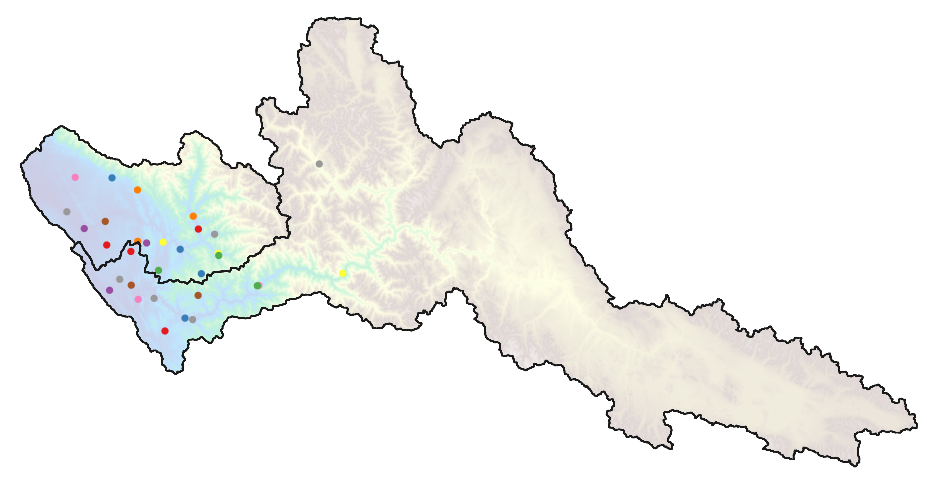

In [555]:
plot_map_stations_cv(st_test)